# Grundläggande analys och statistik

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

In [3]:
# Läsning av datasetet
df = pd.read_csv("../data/health_study_dataset.csv")

# Snabb kontroll
print(df.sample(5))
print()
print(df.info())
print()
print(df.describe())

      id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
400  401   26   M   185.2    78.4        140.0         2.64     No        0
217  218   46   F   161.4    66.1        137.1         4.72     No        0
232  233   50   M   188.7    90.4        154.8         4.64     No        0
570  571   50   F   169.8    53.7        147.2         3.47     No        0
724  725   52   M   176.4    85.1        151.2         4.40     No        0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      8

In [4]:
# Städning
df.isna().sum()
df.duplicated().sum()

np.int64(0)

## Inledande observation

- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden

## Beskrivande analys

In [5]:
# Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
desc_stat = df[["age","weight","height","systolic_bp","cholesterol"]].agg(["mean", "median", "min", "max"])
print(desc_stat)

           age   weight   height  systolic_bp  cholesterol
mean    49.426   73.413  171.849      149.179        4.929
median  50.000   73.200  171.350      149.400        4.970
min     18.000   33.700  144.400      106.800        2.500
max     90.000  114.400  200.400      185.900        7.880


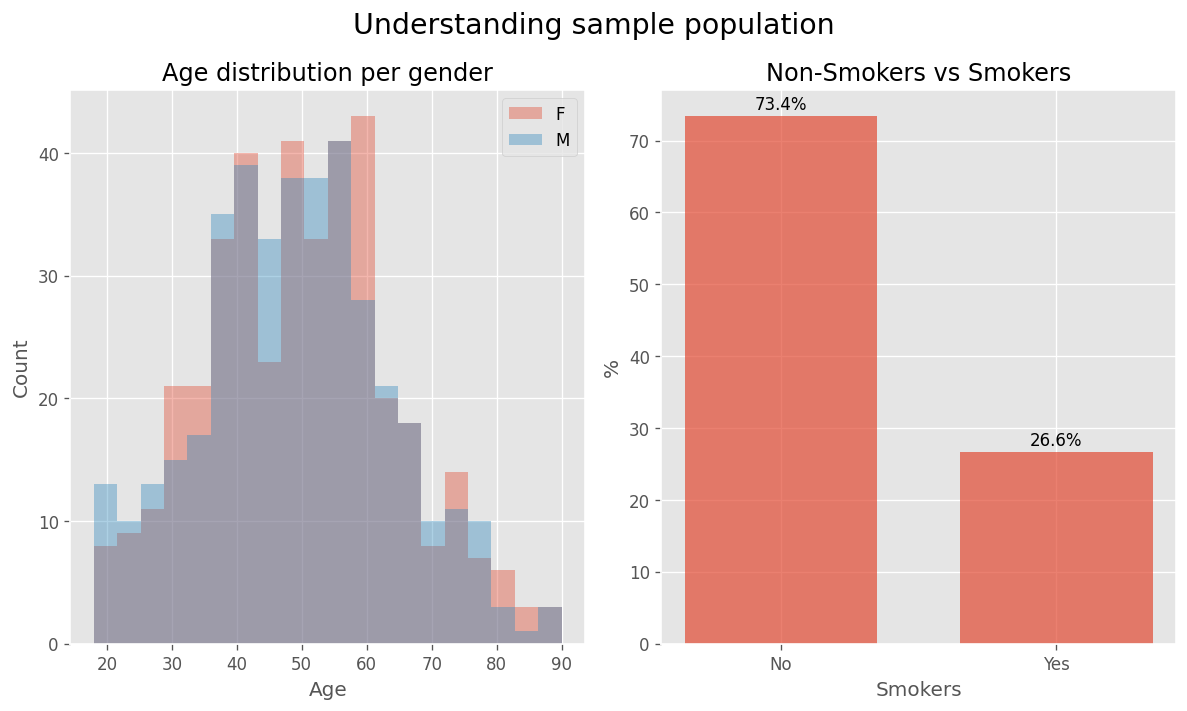

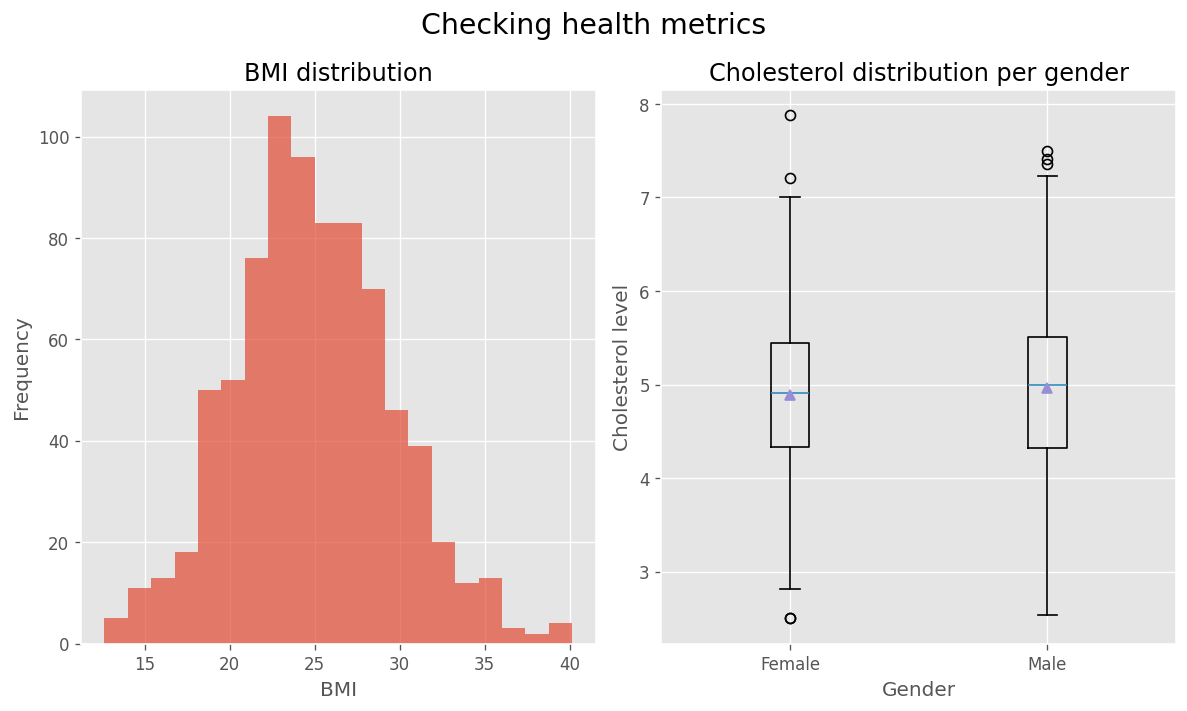

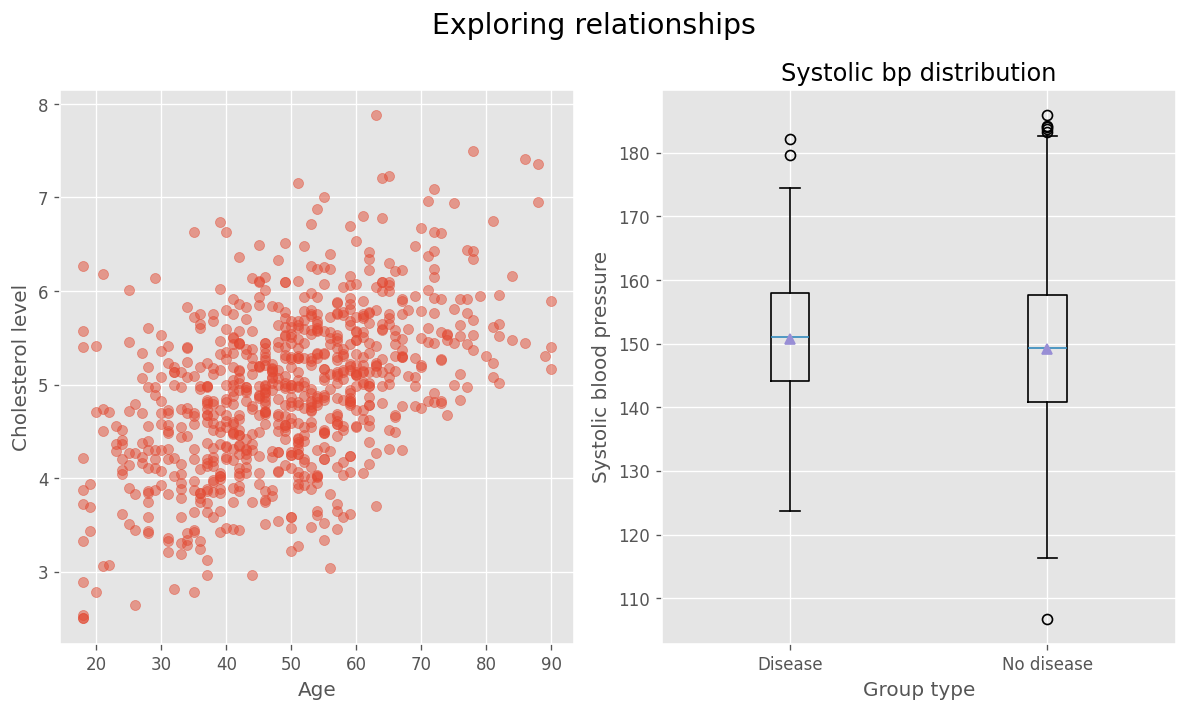

In [6]:
# Histogram: åldersfördelning efter kön
fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.suptitle("Understanding sample population", fontsize=17)

for s, subset in df.groupby("sex"):
    ax1.hist(subset["age"], bins=20, label=f"{s}", alpha=0.4)
ax1.set_title("Age distribution per gender")
ax1.set_xlabel("Age")
ax1.set_ylabel("Count")
ax1.legend()

# Stapeldiagram: andel rökare
smoker_per = (df["smoker"].value_counts() / df["smoker"].count()) * 100

ax2.bar(smoker_per.index, smoker_per.values, width=0.7, alpha=0.7)
ax2.set_title("Non-Smokers vs Smokers")
ax2.set_xlabel("Smokers")
ax2.set_ylabel("%")
for i, v in enumerate(smoker_per.values):
    ax2.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()

# Histogram: BMIfördelning
fig2, (ax3, ax4) = plt.subplots(1, 2)
fig2.suptitle("Checking health metrics", fontsize=17)

df["bmi"] = df["weight"] / (df["height"] / 100)**2
ax3.hist(df["bmi"], bins=20, alpha=0.7)
ax3.set_title("BMI distribution")
ax3.set_xlabel("BMI")
ax3.set_ylabel("Frequency")

# Boxplot: cholesterol efter gender
ax4.boxplot([df.loc[df.sex == "F", "cholesterol"], 
           df.loc[df.sex == "M", "cholesterol"]], 
           tick_labels=["Female", "Male"], 
           showmeans=True)
ax4.set_title("Cholesterol distribution per gender")
ax4.set_xlabel("Gender")
ax4.set_ylabel("Cholesterol level")
plt.tight_layout()
plt.show()

# Scatter: age vs cholesterol
fig3, (ax5, ax6) = plt.subplots(1, 2)
fig3.suptitle("Exploring relationships", fontsize=17)

ax5.scatter(df["age"], df["cholesterol"], alpha=0.5)
ax5.set_xlabel("Age")
ax5.set_ylabel("Cholesterol level")

# Boxplot: systoliskt blodtryck efter grupp med/utan sjukdom
ax6.boxplot([df.loc[df.disease == 1, "systolic_bp"], 
           df.loc[df.disease == 0, "systolic_bp"]], 
           tick_labels=["Disease", "No disease"], 
           showmeans=True)
ax6.set_title("Systolic bp distribution")
ax6.set_xlabel("Group type")
ax6.set_ylabel("Systolic blood pressure")
plt.tight_layout()
plt.show()

**Insights**:
1. Males and females are fairly evenly represented across the age spectrum and there is a lower prevalence of smokers.
2. Normal weight range with few extremes. Similar cholesterol levels between females and males.
3. Scatter shows that as age increases the colesterol level tends to rise. The systolic blood pressure is similar across groups with or without disease so it doesn't seem like the systolic BP alone can indicate a grouo with or without disease.

## Simulering kopplad till caset

In [ ]:
np.random.seed(42) 

# Proportion of people with disease
p_disease = df["disease"].mean()

# Simulation of a 1000 random individuals with same disease proportion
simulated_1000_people = np.random.choice([0, 1], size=1000, p=[1 - p_disease, p_disease])

# Counting proportion of people with desease in simulation
simulated_p_disease = simulated_1000_people.mean()

# Comparing
print(f"Real disease rate: {p_disease * 100:.2f}%.\n"
      f"Simulated disease rate: {simulated_p_disease * 100:.2f}%.")

Real disease rate: 5.88%.
Simulated disease rate: 5.60%.


**Coclusion**:
The difference between the real disease rate and the simulated disease rate is small and falls within the expected variability.

## Konfidensintervall

- Beräkna ett konfidensintervall för medelvärdet av systolic_bp (t.ex. med normalapproximation eller bootstrap, som vi gått igenom på kursen).


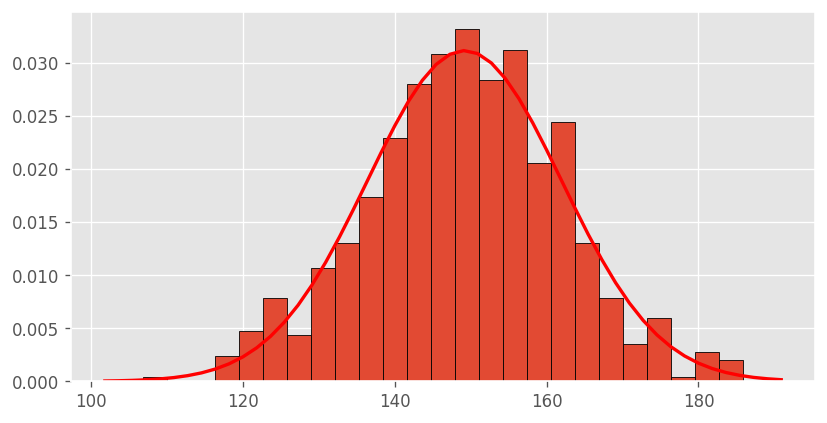

In [ ]:
# Is it really normally distributed?
systolic_bp = df["systolic_bp"]
def normal_pdf(x, m, s):
    x = np.asanyarray(x, dtype=float)
    if s <= 0 or not np.isfinite(s):
        raise ValueError("s has to be a positive and finite number")
    
    norm = 1.0 / (s * np.sqrt(2.0 * np.pi))
    z = (x - m) / s
    y = norm * np.exp(-0.5 * z**2)
    return y

x_support = np.linspace(systolic_bp.min()-5, systolic_bp.max()+5)

fix, ax = plt.subplots(figsize=(8,4))
ax.hist(systolic_bp, bins=25, edgecolor="black", density=True)

m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)

ax.plot(x_support, normal_pdf(x_support, m, s), color="red", lw=2, label="Normal (med vårt medel och std)")
plt.show()

# Yep, it is

In [28]:

systolic_bp = np.array(df["systolic_bp"], dtype=float)
confidence = 0.95
m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)
n = len(systolic_bp)
z = 1.96

# Normal approximation
margin_error = z * (s / np.sqrt(n))
lo = m - margin_error
hi = m + margin_error

print(f"Summary with normal approximation:\n"
      f"Point of estimate: {m}\n"
      f"Standard error:{margin_error}\n"
      f"Lower 95% CI bound: {lo}\n"
      f"Upper 95% CI bound: {hi}")
# SHould I show an error bar?

# Bootstrap
B = 3000
boot_means = np.empty(B)
for b in range(B):
    boot_sample = np.random.choice(systolic_bp, size=n, replace=True)
    boot_means[b] = np.mean(boot_sample)

alpha = (1 - confidence) / 2
blo, bhi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])

print(f"Summary with boothstrap:\n"
      f"Point of estimate: {m}\n"
      f"Lower 95% CI bound: {blo}\n"
      f"Upper 95% CI bound: {bhi}")
# another graph?


Summary with normal approximation:
Point of estimate: 149.178625
Standard error:0.8865346397465568
Lower 95% CI bound: 148.29209036025347
Upper 95% CI bound: 150.06515963974655
Summary with boothstrap:
Point of estimate: 149.178625
Lower 95% CI bound: 148.2763625
Upper 95% CI bound: 150.08899375000001


Conclusion:
Both the methods gave a very similar result.

**Hypotesprövning**

- Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.”
- Använd en av metoderna vi gått igenom (t.ex. bootstrap eller enkel t-test-funktion).
- Förklara kort resultatet i en markdown-ruta.

### **För VG ska du även göra:**

- Beräkna konfidensintervallet med **två olika metoder** (t.ex. normalapproximation och bootstrap) och jämför resultaten.
- Gör en simulering för att undersöka **hur säkert ditt hypotes­test är** (t.ex. hur ofta testet hittar en skillnad när den finns → power).
- Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.